**XGBoost**

In [1]:
import pandas as pd

# Read the CSV file with a specified encoding
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)

# Display the first 5 rows
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum
0,1998,1,1,2,5,1998-01-02,NW,19386,NW,N297US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,2,5,28,4,2009-05-28,FL,20437,FL,N946AT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,2,6,29,6,2013-06-29,MQ,20398,MQ,N665MQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,3,8,31,2,2010-08-31,DL,19790,DL,N6705Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,1,1,15,7,2006-01-15,US,20355,US,N504AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# --- Preprocessing ---
# Fill missing values for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [4]:
# Create binary target variable 'DelayCategory': 1 if there was an arrival delay (ArrDelay > 0), 0 if there wasn't
df['DelayCategory'] = df.apply(lambda row: 1 if row['ArrDelay'] > 0 else 0, axis=1)

In [5]:
# Encode 'DelayCategory'
le = LabelEncoder()
df['DelayCategory'] = le.fit_transform(df['DelayCategory'])

In [ ]:
# Feature engineering (time-related features)
df['ArrTime_combined'] = df['ArrTime'] // 100 * 60 + df['ArrTime'] % 100

# Time of day: 7 AM to 1 PM window for arrival
df['DayArrivalFlight'] = df['ArrTime_combined'].apply(lambda x: 1 if 420 <= x <= 780 else 0)  # 7 AM to 1 PM

# Seasonal and time-of-day features
# Updated months for seasonal delays: December, February, April, July, August
df['HighDelaySeason'] = df['Month'].apply(lambda x: 1 if x in [2, 4, 7, 8, 12] else 0)

# Create binary features based on TaxiIn and TaxiOut times
df['TaxiIn_Long'] = df['TaxiIn'].apply(lambda x: 1 if x > 10 else 0)
df['TaxiOut_Long'] = df['TaxiOut'].apply(lambda x: 1 if x > 10 else 0)

# Add the weekend feature (IsWeekend)
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)  # 5 for Saturday, 6 for Sunday

# Add the airline delay flag based on specific airlines (e.g., 'PI', 'AAPS')
df['HighDelayAirline'] = df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AA', 'PS'] else 0)

# Add binary flag for high-delay weekdays (Wednesday=3, Thursday=4)
df['HighDelayWeekday'] = df['DayOfWeek'].apply(lambda x: 1 if x in [3, 4] else 0)

# Define the top states
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']

# Create the features
df['HighDelayOriginState'] = df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
df['HighDelayDestState'] = df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Features for training
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',  'ArrTime_combined',
            'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Flights', 'Distance', 
            'HighDelaySeason', 'DayArrivalFlight', 'TaxiOut_Long', 'TaxiIn_Long', 'IsWeekend', 
            'HighDelayAirline', 'HighDelayOriginState', 'HighDelayDestState', 'HighDelayWeekday']

# Features matrix and target vector
X = df[features]
y = df['DelayCategory']

In [7]:
# Label encode any object/categorical columns (just in case)
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

# Fill any remaining missing values
X = X.fillna(X.median())

# --- Standardization (important for Logistic Regression) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**SMOTE**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- Train-test split (Stratified Split) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Scaling: Fit scaler on training data and transform both train and test sets ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Apply SMOTE to training data ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- XGBoost model without scale_pos_weight (SMOTE already balances classes) ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='map',
    n_estimators=1000,
    tree_method='hist',
    verbosity=0,
    random_state=42
)

# --- Train the model ---
xgb_model.fit(X_train_resampled, y_train_resampled)

# --- Predict and evaluate ---
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Print F1 score ---
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print("XGBoost F1 Score (weighted):", f1)

# --- Print classification report ---
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# --- Print confusion matrix ---
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

**Handle Imbalance**

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- Train-test split (Stratified Split) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Scaling: Fit scaler on training data and transform both train and test sets ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ratio_of_classes = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# --- XGBoost model with tuned parameters ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='map',
    n_estimators=1000,
    tree_method='hist',
    verbosity=0,
    random_state=42,
    scale_pos_weight=ratio_of_classes
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# --- Get predicted probabilities --- 
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1 (delayed flights)

# --- Set a custom threshold for classification --- 
threshold = 0.5  # You can adjust this value (0.3, 0.4, etc.)
y_pred_class = (y_pred_prob >= threshold).astype(int)

# --- Print F1 score ---
f1 = f1_score(y_test, y_pred_class, average='weighted')
print("XGBoost F1 Score (weighted):", f1)

# --- Print classification report ---
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_class))

# --- Print confusion matrix ---
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))


XGBoost F1 Score (weighted): 0.8038689083163284

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84    228089
           1       0.81      0.72      0.76    171911

    accuracy                           0.81    400000
   macro avg       0.81      0.79      0.80    400000
weighted avg       0.81      0.81      0.80    400000


XGBoost Confusion Matrix:
[[199406  28683]
 [ 48987 122924]]


**Feature Importance**

Top 10 Features by Importance:
              Feature  Importance
6      CRSElapsedTime    0.223009
13       TaxiOut_Long    0.222894
7   ActualElapsedTime    0.169284
14        TaxiIn_Long    0.106862
5    ArrTime_combined    0.048855
0                Year    0.035275
12   DayArrivalFlight    0.022086
2               Month    0.021445
4           DayOfWeek    0.018122
8             AirTime    0.016716


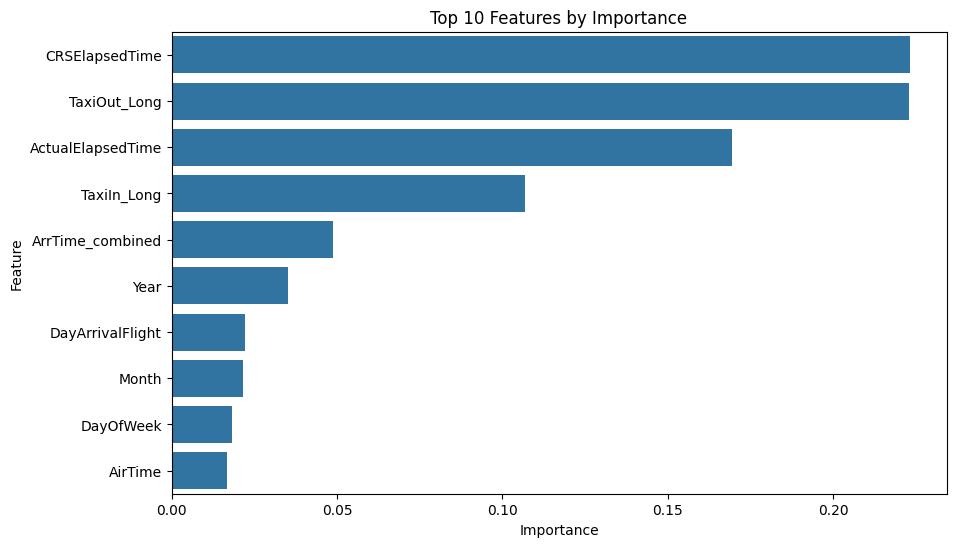

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns 

# --- Get feature importance ---
feature_importance = xgb_model.feature_importances_

# --- Sort the features by importance ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# --- Print the top features ---
print("Top 10 Features by Importance:")
print(importance_df.head(10))

# --- Plot feature importance using matplotlib ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Top 10 features
plt.title('Top 10 Features by Importance')
plt.show()

**Before Handling Imbalance**

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- Train-test split (Stratified Split) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Scaling: Fit scaler on training data and transform both train and test sets ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- XGBoost model with tuned parameters ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='map',
    n_estimators=1000,
    tree_method='hist',
    verbosity=0,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# --- Predict and evaluate ---
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Print F1 score ---
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print("XGBoost F1 Score (weighted):", f1)

# --- Print classification report ---
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# --- Print confusion matrix ---
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost F1 Score (weighted): 0.8057534306186801

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85    228089
           1       0.85      0.67      0.75    171911

    accuracy                           0.81    400000
   macro avg       0.82      0.79      0.80    400000
weighted avg       0.82      0.81      0.81    400000


XGBoost Confusion Matrix:
[[208140  19949]
 [ 56076 115835]]


**F1-Score**

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# --- Train-test split (Stratified Split) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Scaling: Fit scaler on training data and transform both train and test sets ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- XGBoost model with tuned parameters ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='map',
    n_estimators=1000,
    tree_method='hist',
    verbosity=0,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# --- Predict and evaluate ---
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Print F1 score ---
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print("XGBoost F1 Score (weighted):", f1)

XGBoost F1 Score (weighted): 0.8057534306186801


**LightGBM**

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Features matrix and target vector
X = df[features]
y = df['DelayCategory']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class imbalance ratio
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set the parameters for LightGBM with imbalance handling
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'verbose': -1,
}

# Train the model
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])

# Make predictions on the test data
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Convert probabilities to binary labels using lower threshold to boost recall for class 1
y_pred_binary = (y_pred >= 0.4).astype(int)

# Print classification report and confusion matrix
print("--- LightGBM Classification Report ---")
print(classification_report(y_test, y_pred_binary))

# Print F1 Score
f1 = f1_score(y_test, y_pred_binary)
print("LightGBM F1 Score:", f1)

# Print Confusion Matrix
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

--- LightGBM Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81    228010
           1       0.73      0.78      0.76    171990

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.79      0.78      0.79    400000

LightGBM F1 Score: 0.7572742874827674
LightGBM Confusion Matrix:
[[179149  48861]
 [ 37411 134579]]


**Taxi Details**

In [21]:
# Calculate correlation matrix
correlation_matrix = df[['TaxiIn', 'TaxiOut', 'DepDelay', 'ArrDelay']].corr()

# Display the correlation matrix
print(correlation_matrix)

            TaxiIn   TaxiOut  DepDelay  ArrDelay
TaxiIn    1.000000  0.049393  0.012460  0.066857
TaxiOut   0.049393  1.000000  0.073118  0.257508
DepDelay  0.012460  0.073118  1.000000  0.898746
ArrDelay  0.066857  0.257508  0.898746  1.000000


In [20]:
# Assuming 'TaxiIn' and 'TaxiOut' are columns in the dataset
print(df[['TaxiIn', 'TaxiOut']].head())  # Preview the first 5 rows of TaxiIn and TaxiOut data

   TaxiIn  TaxiOut
0     3.0     24.0
1     8.0     10.0
2     6.0      9.0
3     7.0     23.0
4     8.0     19.0


In [22]:
# Set a threshold for TaxiIn or TaxiOut (e.g., greater than 10 minutes)
threshold = 10

# Filter for rows where TaxiIn or TaxiOut is greater than the threshold
high_taxi_in = df[df['TaxiIn'] > threshold]
high_taxi_out = df[df['TaxiOut'] > threshold]

# Check the delays for these cases
high_taxi_in_delays = high_taxi_in[['TaxiIn', 'DepDelay', 'ArrDelay']]
high_taxi_out_delays = high_taxi_out[['TaxiOut', 'DepDelay', 'ArrDelay']]

# Calculate average delays for these cases
avg_delay_taxi_in = high_taxi_in_delays.mean()
avg_delay_taxi_out = high_taxi_out_delays.mean()

# Display the results
print("Average delays for flights with TaxiIn > {} minutes:".format(threshold))
print(avg_delay_taxi_in)

print("Average delays for flights with TaxiOut > {} minutes:".format(threshold))
print(avg_delay_taxi_out)

Average delays for flights with TaxiIn > 10 minutes:
TaxiIn      16.580352
DepDelay     9.038974
ArrDelay    12.262727
dtype: float64
Average delays for flights with TaxiOut > 10 minutes:
TaxiOut     17.257763
DepDelay     8.584457
ArrDelay     7.474424
dtype: float64
